<a href="https://colab.research.google.com/github/Regis0323/Module_1/blob/main/Module_1_Session_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="background-color: #004B87; padding: 20px; border-radius: 10px;">
<center>
<img src="https://cdn-assets-us.frontify.com/s3/frontify-enterprise-files-us/eyJwYXRoIjoibWlsbGltYW5cL2ZpbGVcL2l3dHhYOHJqV3pVUUV0R3hLc0FGLnN2ZyJ9:milliman:1F1qJpvDxGMTndryYS7nEiCYPRFCCi7l2rEhgnpdkGo?width=2400" width="300" height="150" alt="SVG Image" />

<h1 style="color:#FFFFFF;">IABE Data Science Certificate - Module 1 - Session 2</h1>

<h2 style="color:#FFFFFF;">Programming: Linear models & Generalized linear models</h2>

<h2 style="color:#FFFFFF;">28th November, 2024</h2>
</center>
</div>

# 1. Introduction<a name="Introduction"></a>
  
Welcome to the second programming session of the Actuarial Data Scientist training program. This class continues a series of twelve practical sessions divided in three main modules. These presentations aim to concretely illustrate how a variety of data science techniques can be applied in an actuarial context.
<br />
<br />
This session will primarly focus on linear models (LMs) and generalized linear models (GLMs). The objective will be first to build upon previous knowledge to create adequate linear models. For this purpose, new concepts will also be introduced to assess the fit of the model (etc. p-values, R<sup>2</sup> and AIC/BIC). Afterwards, GLMs will be discussed. The aim will be to give attendands a good initial grasp on the reasons GLMs should be used, how data should be initially treated and how to assess the fit of the model.  

To illustrate this session, the same housing dataset will be first used to introduce linear models. Subsequently, we will rely on two linked MTPL data sets on frequency and severity of motor insurance claims to fit different types of GLM.

<ins>**Overview**</ins>
1. [Introduction](#Introduction)<br />
2. [Importing and cleaning data](#Importing_and_cleaning_data)<br />
3. [Linear Models in Python](#Linear_Models)<br />
    3.1. [Main packages used](#main_packages_used)<br />
    3.2. [T-statistic & p-value](#t_statistic_p_value)<br />
    3.3. [R-squared](#R-squared)<br />
    3.4. [AIC and BIC](#AIC_and_BIC)<br />
4. [Training Linear models](#Training_linear_models)<br />4.1. [Model with one explanatory variable](#Model_with_one_explanatory_variable)<br />
    4.2. [Model with multiple explanatory variables](#Model_with_selected_variables)<br />
5. [Generalized Linear Models](#General_linear_Models)<br />
    5.1. [Preliminary analysis on the frequency dataset](#Preliminary_analysis)<br />
    5.2. [Preliminary feature treatment](#Preliminary_feature_treatment)<br />
    5.3. [Mean-variance relationship](#mean_var_rel)<br />
    5.4. [Model with a Poisson distribution](#Poisson_distribution)<br />
    5.5. [Model with a Negative Binomial distribution](#NB_distribution)<br />
    5.6. [Severity dataset and Gamma distirbution](#sev_data)<br />


## Speakers

**Bjorn Blom**
<br />
Bjorn Blom is a consultant with 6+ years of experience in data science, process optimization and modelling in the insurance sector.
<br />
Mail address: bjorn.blom@milliman.com


**Daniël Van Dam**
<br />
Daniël is a consultant with 9+ years of experience in the financial sector, with experience in AI and data science.
<br />
Mail address: daniel.vandam@milliman.com


## Resources
<ins>**Books**</ins>
<br />
<br />
James, G., Witten, D., Hastie, T., Tibshirani, R., & Taylor, J. (2023). An introduction to statistical learning: With applications in python (2023rd ed.). New York, NY: Springer.
<br />
Charpentier, A. (Ed.). (2016). Computational actuarial science with R. London, England: CRC Press.
<br />
<br />
<ins>**Datasets**</ins>
1. [Ames Housing dataset](https://www.kaggle.com/datasets/prevek18/ames-housing-dataset)<br />
2. French MTPL datasets
<br />a. [Frequency data](https://www.kaggle.com/datasets/floser/french-motor-claims-datasets-fremtpl2freq)
<br />b. [Severity data](https://www.kaggle.com/datasets/floser/fremtpl2sev)

# 2. Importing and cleaning data <a name="Importing_and_cleaning_data"></a>
## Importing packages <a name="Importing_packages"></a>

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
import seaborn as sns

## Loading data <a name="Loading_data"></a>

Similarly to the previous session, the Ames housing dataset will be used for the first part of the session. It consists on 2930 observations on residential homes in Iowa and it is particularly suitable for linear regression. Afterwards, two linked French motor third-party liability insurance (MTPL) datasets on frequency and severity are loaded to present how to use different GLM models.

In [ ]:
ames_data = pd.read_csv("/content/sample_data/AmesHousing.csv")
mtpl_freq = pd.read_csv("/content/sample_data/freMTPL2freq.csv")
mtpl_sev = pd.read_csv("/content/sample_data/freMTPL2sev.csv")

## Dealing with NaN values<a name="Dealing_with_NaN_values"></a>
Observations with NaN values cannot be used for some of the functions used to fit a linear regression (etc. the stepwise selection processes covered in section [4.2.](#Variable_selection)). Similarly to the previous session, the variables that contain more than 40% of NaN values are dropped then the remaining NaN values are substituted with the mode or the mean per variable.

In [ ]:
# Discarding variables with too many NA values
deleted_var = []
percentage = 0.4
for i in list(ames_data):
  if ames_data[i].isna().sum()/len(ames_data.index) > percentage:
   deleted_var.append(i)
   ames_data.drop(i, axis = 1, inplace = True)

print("These variables have been deleted:")
print(deleted_var)

These variables have been deleted:
['Alley', 'Mas Vnr Type', 'Fireplace Qu', 'Pool QC', 'Fence', 'Misc Feature']


In [ ]:
# Replacing NA values by the mode ot the mean
for i in list(ames_data):
  if ames_data[i].dtype == 'object':
    val = ames_data[i].mode()[0]
    ames_data[i] = ames_data[i].fillna(val)
  elif pd.api.types.is_numeric_dtype(ames_data[i]):
    val = ames_data[i].mean()
    ames_data[i] = ames_data[i].fillna(val)

# 3. Linear Models in Python <a name="Linear_Models"></a>

Linear regression is one of the most standard approaches to supervised learning. This statistical technique is widely used, not only in finance but also in numerous other disciplines. While linear regression is less advanced than some other methods, it is intuitive and has many practical uses. Linear regression can also be generalized or extended. It is thus key to have a good understanding of this technique before diving into more advanced topics.
<br/>
As seen in the theoretical module,  the aim of the linear regression is to find the linear relationship between the dependent variable $Y$ and p explanatory variables $x_1, ... x_p$. For this purpose, the unknown parameters $\beta_0, \beta_1, ..., \beta_p$ (the intercept and the slope terms associated to the explanatory variables) need to be estimated. This basic model is shown below  
<br/>
$$Y \approx \beta_0+\beta_1 x_1+...++\beta_p x_p.$$
<br/>
To properly fit the model, the differences between observed data and the model's predictions must be minimized. This is called residual sum of squares (RSS) and it is defined for observations i = 1, ... ,n as
<br/>
<br/>

$$\operatorname{RSS}=\left(y_1-\hat{\beta}_0-\hat{\beta}_1 x_{1,1}-...-\hat{\beta}_p x_{p,1}\right)^2+\left(y_2-\hat{\beta}_0-\hat{\beta}_1 x_{1,2}-...-\hat{\beta}_p x_{p,2}\right)^2+...+\left(y_n-\hat{\beta}_0-\hat{\beta}_1 x_{1,n}-...- \hat{\beta}_p x_{p,n}\right)^2.$$

<br/>

The Ordinary Least Squares regression (OLS) is used to find the optimal coefficients that minimize the RSS. In its matrix form, $\hat{\beta}$ represents the estimated coefficients, $X$ the nxp matrix containg the n observations of the p explanatory variables and $Y$ the nx1 vector containing the n observations of the dependent variable. It is equal to
<br/>
<br/>
$$\hat{\beta}=\left(X^{\mathrm{T}} X\right)^{-1} X^{\mathrm{T}} Y.$$
<br/>

The variance-covariance matrix of $\hat{\beta}$ is given by

$$
E\left[(\hat{\beta}-\beta)(\hat{\beta}-\beta)^{\mathrm{T}}\right] = \mathrm{SE}(\hat{\beta})^{2} = \sigma^2\left(X^{\mathrm{T}} X\right)^{-1}.
$$

Here, $\sigma^2$ represents the mean square error. The diagonal of this matrix is then a vector with variances of the individual estimated coefficients. Further information is available [here](https://web.stanford.edu/~mrosenfe/soc_meth_proj3/matrix_OLS_NYU_notes.pdf).<br/><br/>

## 3.1 Main packages used <a name="main_packages_used"></a>
Linear regression can be applied in Python with packages ```statsmodel``` and ```sklearn```. While key metrics are available with both packages, ```statsmodel``` is more tailored towards explanatory analysis while ```sklearn``` is better designed for prediction.

<ins>**Linear regression using package statsmodel**</ins><br/>
To begin, let's start with the function ```sm``` from package ```statsmodel```. To illustrate, a model is fitted with the explanatory variables *Overall Qual* and *MS SubClass* and dependend variable *SalePrice*. Function ```summary()``` provides an overview of the different variables, as well as different metrics to assess the quality of the model. More possible functions which can be used on the fitted model can be found [here](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.html#statsmodels.regression.linear_model.RegressionResults) on the bottom of the page.

From the table below, it is possible to quickly observe the estimated coefficients of the regression. The intercept equals -84.036, the coefficient for the explanatory variable *Overall Qual* stands at 45.551 and the one for *MS SubClass* at -218.80. Their rounded p-value is 0, making the variables and the intercept statistically significant for the explanation of the dependent variable.

In [ ]:
x = ames_data[['MS SubClass', 'Overall Qual']]
x = sm.add_constant(x) # a vector with values 1 is added to account for the offset parameter
y = ames_data['SalePrice']
model = sm.OLS(y, x)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     2747.
Date:                Mon, 25 Nov 2024   Prob (F-statistic):               0.00
Time:                        18:56:44   Log-Likelihood:                -35684.
No. Observations:                2930   AIC:                         7.137e+04
Df Residuals:                    2927   BIC:                         7.139e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -8.404e+04   3993.207    -21.045      0.000   -9.19e+04   -7.62e+04
MS SubClass   -218.7972     20.432    -10.708      0.000    -258.861    -178.734
Overall Qual  4.551e+04    617.424     73.712      0.000    4.43e+04    4.67e+04
==============================================================================
Omnibus:                      987.393   Durbin-Watson:                   1.447
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7092.700
Skew:                           1.408   Prob(JB):                         0.00
Kurtosis:                      10.083   Cond. No.                         332.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This package will be used in the following sections.

<br/><ins>**Linear regression using package sklearn**</ins><br/>
Function ```LinearRegression()``` from package ```sklearn``` can also be used. Here is an example:

In [ ]:
#Linear regression
model_lr = LinearRegression().fit(x, y)
params = np.append(model_lr.intercept_,model_lr.coef_)
print("Parameters of the linear regression:", params[0].round(1), ",", params[2].round(1), "and", params[3].round(1))

Parameters of the linear regression: -84035.8 , -218.8 and 45511.6


<ins>**Linear regression with standard algebra**</ins><br/>
While it is more convenient to use ```statsmodel``` or ```sklearn``` to create a linear model, it is also possible to use algebra to estimate coefficients manually. Note that the coefficients are equivalent the previous ones.  

In [ ]:
# Define dependent and independent variables
x = ames_data[['MS SubClass', 'Overall Qual']]
x = sm.add_constant(x)
y = ames_data['SalePrice']

# Calculate the OLS estimator: beta = (X'X)^(-1)X'y
X_transpose = np.transpose(x)
X_transpose_X = np.dot(X_transpose,x)
X_transpose_X_inv = np.linalg.inv(X_transpose_X)
X_transpose_y = np.dot(X_transpose, y)

# Find beta
beta = np.dot(X_transpose_X_inv, X_transpose_y)
print("Parameters of the linear regression:", beta[0].round(1), ",", beta[1].round(1), "and", beta[2].round(1))

Parameters of the linear regression: -84035.8 , -218.8 and 45511.6


Notice that the estimated values are the same with all three methods. This proves that the underlying models used in the packages are equal and following the expected formulas. Hence, we will use the statsmodel package for our modelling in the remaining part of this session.

## 3.2. t-statistic & p-value<a name="t_statistic_p_value"></a>

A t-statistic measures the standardized difference between the estimated parameter and its value under the null hypothesis. Mathematically, it is defined as

$$t=\frac{\hat{\beta}-\beta_0}{\mathrm{SE}(\hat{\beta})}$$

where $\hat{\beta}$ correponds to the estimated coefficients, $\beta_0$ an array of known values (null vector for the null-hypothesis) and $\mathrm{SE}(\hat{\beta})$ the standard error of the estimated coefficients. It is the square root of the variances of the individual estimated coefficients defined [above](#Linear_Models). A large t-statistic means it is far from the expected coefficient value. For a null-hypothesis test, it means the coefficient is probably significant.

The p-value relies on the t-statistic to assess how likely it is to have test results as extreme as the ones observed if the null-hypothesis is respected. A low p-value (usually <0.05) shows that the null-hypothesis must be rejected and the variable is statically significant. It shows that the odd that it happened by chance is low. Inversely, a high p-value means the variable is unlikely to be statiscally significant.

Below, you can see that these statistics can be found in the summary under columns **t** for the t-statistic and **P>|t|** for the p-value next in the variables table:

In [ ]:
x = ames_data[['MS SubClass', 'Overall Qual']]
x = sm.add_constant(x) # a vector with values 1 is added to account for the offset parameter
y = ames_data['SalePrice']
model = sm.OLS(y, x)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     2747.
Date:                Mon, 25 Nov 2024   Prob (F-statistic):               0.00
Time:                        19:21:47   Log-Likelihood:                -35684.
No. Observations:                2930   AIC:                         7.137e+04
Df Residuals:                    2927   BIC:                         7.139e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -8.404e+04   3993.207    -21.045      0.000   -9.19e+04   -7.62e+04
MS SubClass   -218.7972     20.432    -10.708      0.000    -258.861    -178.734
Overall Qual  4.551e+04    617.424     73.712      0.000    4.43e+04    4.67e+04
==============================================================================
Omnibus:                      987.393   Durbin-Watson:                   1.447
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7092.700
Skew:                           1.408   Prob(JB):                         0.00
Kurtosis:                      10.083   Cond. No.                         332.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

They can also be extracted using the following command:

In [ ]:
print("t-statistic: ")
print(sm.OLS(y, x).fit().tvalues)
print("---------------------------------------------------------------------")
print("p-value: ")
print(sm.OLS(y, x).fit().pvalues)

t-statistic: 
const          -21.044689
MS SubClass    -10.708299
Overall Qual    73.712165
dtype: float64
---------------------------------------------------------------------
p-value: 
const           1.133734e-91
MS SubClass     2.834099e-26
Overall Qual    0.000000e+00
dtype: float64


# 3.3. R-squared<a name="R-squared"></a>

$R^{2}$ is the proportion of variation of the dependent variable predicted using explanatory variables. It shows the predictive power of the model. A score of 1 means the model fully explains the dependent variable y. It is represented as

$$
R^2= 1-\frac{RSS}{TSS} = 1-\frac{\sum_i\left(y_i-\hat{y}_i\right)^2}{\sum_i\left(y_i-\mu\right)^2} .
$$

This statisics is displayed in the summary of of the function ```OLS``` from library ```statsmodels```. In the model previously developed [here](#Different_packages), it is equal to 0.652. The same value can be extracted from the summary using command ```model.rsquared```.
Let us use the split introduced in the previous programming session and calculate this statistics in both the train and test datasets:

In [ ]:
x = ames_data[['MS SubClass', 'Overall Qual']]
y = ames_data['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 12)
'MS SubClass', 'Overall Qual'

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train).fit()
y_pred = model.predict(X_test)

R2_train_set = model.rsquared
R2_test_set = r2_score(y_test, y_pred)

# R2 on the train dataset
print("R2 on the train dataset:", round(R2_train_set, 3))
# R2 on the test dataset
print("R2 on the test dataset:", round(R2_test_set, 3))

R2 on the train dataset: 0.661
R2 on the test dataset: 0.633


$R^{2}$ decreases from 66% to 63% when the model is used to predict outcomes from the test data set. It shows that the model is only slightly overfitting on the train set. Few non-relevant data (noises) are used to explain the dependent variable.

# 3.4. AIC and BIC<a name="AIC_and_BIC"></a>
The Akaike information criterion (AIC) and Bayesian information criterion (BIC) are two useful statistical measures for model selection. Both of these metrics penalize the number of variables used in a model. Consequently, there is a trade-off between the goodness of fit and excess of parameters. These are suitable measures to avoid excessive overfitting.

The formula for the AIC is the following:
$$A I C=-2 \ln (L)+2 k$$

where $k$ is the number of model parameters and $ln(L)$ is the log-likelihood of the model. A model with a lower AIC is preferable. A newly included variable that does not increase siginificantly the likelihood of the model causes the AIC to increase.

BIC is similarly defined:

$$\mathrm{BIC}=k \ln (n)-2 \ln (L).$$

<br/> where *n* is the sample size. Once again, a model with a lower BIC is preferable. Both of these values can be found in the summary of the function ```OLS``` from library ```statsmodels```, as one can notice [here](#main_packages_used). They can also be extracted using the following command:

In [ ]:
model = sm.OLS(y, sm.add_constant(x)).fit()
aic_value = model.aic
bic_value = model.bic
print("AIC:", round(aic_value, 2))
print("BIC:", round(bic_value, 2))

AIC: 71373.36
BIC: 71391.31


# 4. Training Linear Models <a name="Training_linear_models"></a>

In this section, first a model with just one explanatory variable is presented. Then, more variables are selected. The model is later extended using quadratic terms and categorical variables.


## 4.1. Model with one explanatory variable<a name="Model_with_one_explanatory_variable"></a>
As an introduction, a model with only one variable is set up. The first chosen variable will be *Overall Qual*, a variable with a strong correlation to the dependend variable *SalePrice*.
<br/>From the table below, it is possible to observe the estimated coefficients of the regression. The intercept equals -95 003 and the coefficient for the explanatory variable *Overall Qual* stands at 45 251. Their rounded p-value is 0, making the variable and the intercept statistically significant for the explanation of the dependent variable.

In [ ]:
x = ames_data['Overall Qual']
x = sm.add_constant(x) # a vector with values 1 is added to account for the offset parameter
y = ames_data['SalePrice']
model = sm.OLS(y, x)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     5179.
Date:                Mon, 25 Nov 2024   Prob (F-statistic):               0.00
Time:                        19:32:09   Log-Likelihood:                -35740.
No. Observations:                2930   AIC:                         7.148e+04
Df Residuals:                    2928   BIC:                         7.150e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -9.5e+04   3933.822    -24.150      0.000   -1.03e+05   -8.73e+04
Overall Qual  4.525e+04    628.805     71.964      0.000     4.4e+04    4.65e+04
==============================================================================
Omnibus:                      953.364   Durbin-Watson:                   1.398
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6610.719
Skew:                           1.362   Prob(JB):                         0.00
Kurtosis:                       9.836   Cond. No.                         28.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This model offers a first imperfect calibration. For instance, the offset is negative which is not appropriate as *SalePrice* should always remain positive.

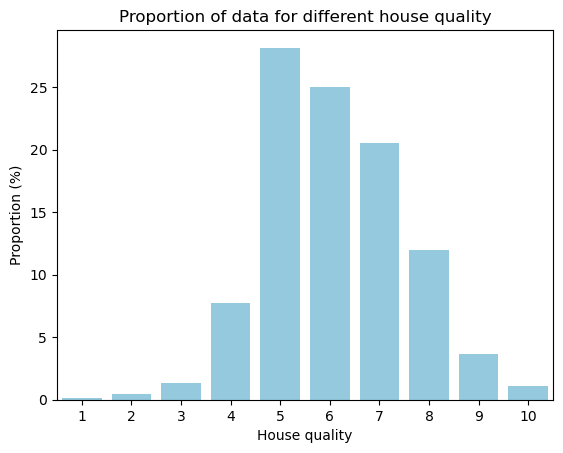

In [ ]:
# Group data by Overall quality
ames_data_quality = pd.DataFrame({'House quality': range(1,11), 'Proportion': ames_data.groupby("Overall Qual").size() / len(ames_data) * 100})

# plot a bar chart
sns.barplot(x = "House quality", y = "Proportion", data = ames_data_quality,color = 'skyblue')

plt.ylabel("Proportion (%)")
plt.title("Proportion of data for different house quality")
plt.show()

From the distribution of available data, it is clear that few data exist below a quality rating of 4 and above a rating of 8. Prediction is thus trickier. Below, a visual representation of the estimated linear regression. Library ```matplotlib``` and ```seaborn``` are used.

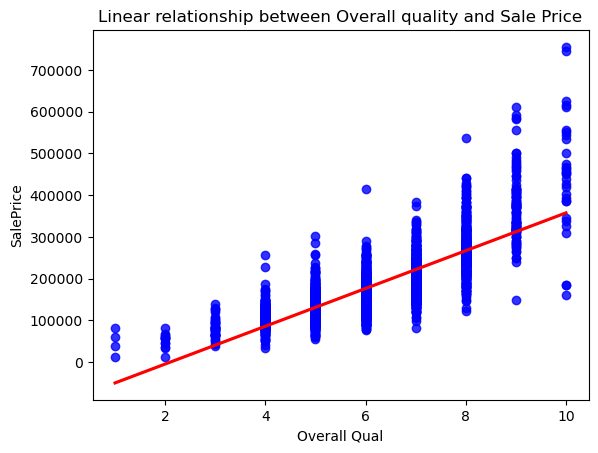

In [ ]:
# Create a graph with a scattered values (parameter scatter_kws) and a standard linear regression (parameter line_kws)
sns.regplot(x="Overall Qual", y="SalePrice", data = ames_data,
                 scatter_kws = {"color": "blue"}, line_kws = {"color": "red"}, ci = None)
plt.title('Linear relationship between Overall quality and Sale Price')
plt.show()

Using this simple regression, it is possible to observe an acceptable fit between quality ratings 4 and 8. Outside of this range, the linear regression performs relatively poorly. Addtionally, the model can be used to predict the value of the *SalePrice* by assigning values to the explanatory variable:

In [ ]:
x = ames_data['MS SubClass']
x = sm.add_constant(x)
y = ames_data['SalePrice']
# Estimation of the model
model_lr = LinearRegression().fit(x, y)

# Prediction settings are defined in a dataframe
parameter_settings = pd.DataFrame({
    'const': [1, 1],
    'MS SubClass': [50, 100]
})

# Predicitons based on the fitted model
prediction = model_lr.predict(parameter_settings)
print("The predicted values for MS SubClass 50 and 100 are:", prediction[0].round(2), "and", prediction[1].round(2))

The predicted values for MS SubClass 50 and 100 are: 181973.81 and 174002.42


# 4.2. Model with multiple explanatory variables<a name="Model_with_selected_variables"></a>
More than one explanatory variable can be used. To select the most relevant ones, stepwise selection is introduced below.



#  Variable selection <a name="Variable_selection"></a>

The selection of variables can be automated using two main strategies: forward and backward stepwise selections.<br/>
<br/><ins>**Forward selection process**</ins><br/>
For the forward process, a model is initially built with only an intercept. An assigned metric for the goodness of fit (etc. $R^{2}$) is chosen and computed for the model. Afterwards, all possible one-variable models are calculated. For each alternative model, the scoring metric is calculated. The model with the best goodness of fit is then chosen. This process continues incrementally with additional variables. By default, it is repeated until the specified number of variables is reached.
<br/><br/><ins>**Backward selection process**</ins><br/>
For a backward selection, a model using all variables is first assessed. Then, the variable which leads to the least significant reduction of the scoring is removed. The process continues until a given number of variables is selected.

Function ```SequentialFeatureSelector``` from package ```sklearn``` implements those two stepwise selection processes. As introduced above, the user can decide to use the forward or backward selection, the number of variables that needs to be selected and the scoring metric used in the process. More information on this function is accessible [here](https://scikit-learn.org/dev/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html) while scoring methods available are detailed [here](https://scikit-learn.org/dev/modules/model_evaluation.html#scoring-parameter).

In [ ]:
# Definition of the explanatory and dependent variable from the retreated dataset
x = ames_data.iloc[:, :-1].select_dtypes(exclude="object")
y = ames_data.iloc[:, -1]

# Desired model to be used
model_lr = LinearRegression()

# Initialize the SequentialFeatureSelector
Selection = SequentialFeatureSelector(
    model_lr,
    n_features_to_select = 5,       # Set the desired number of features
    direction = 'forward',          # Specify forward selection (backward selection can also be used)
    scoring = 'explained_variance', # Choose an evaluation metric (e.g., R-squared, explained variance..)
    cv=5                            # cross-validation splitting strategy
)

# Fit of model
Selection.fit(x, y)

# List of selected variables
selected_vars = x.columns[Selection.get_support()]
print("Selected variables:", selected_vars)

Selected variables: Index(['MS SubClass', 'Overall Qual', 'BsmtFin SF 1', 'Gr Liv Area',
       'Garage Cars'],
      dtype='object')


In [ ]:
# Selecting variables for a new model
x = ames_data[['MS SubClass', 'Overall Qual', 'BsmtFin SF 1', 'Gr Liv Area', 'Garage Cars']]
x = sm.add_constant(x)
y = ames_data['SalePrice']
sm.OLS(y, x).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     2316.
Date:                Mon, 25 Nov 2024   Prob (F-statistic):               0.00
Time:                        19:32:39   Log-Likelihood:                -34886.
No. Observations:                2930   AIC:                         6.978e+04
Df Residuals:                    2924   BIC:                         6.982e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -9.124e+04   3076.424    -29.658      0.000   -9.73e+04   -8.52e+04
MS SubClass   -202.9966     15.713    -12.919      0.000    -233.806    -172.188
Overall Qual  2.665e+04    647.619     41.145      0.000    2.54e+04    2.79e+04
BsmtFin SF 1    32.3134      1.533     21.080      0.000      29.308      35.319
Gr Liv Area     52.6748      1.646     32.010      0.000      49.448      55.901
Garage Cars   1.584e+04   1128.875     14.029      0.000    1.36e+04    1.81e+04
==============================================================================
Omnibus:                     1090.636   Durbin-Watson:                   1.480
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           110467.575
Skew:                          -0.790   Prob(JB):                         0.00
Kurtosis:                      33.039   Cond. No.                     7.74e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.74e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Model with quadratic terms<a name="Model_with_quadratic_terms"></a>
Following an exploratory data analysis (EDA), it might be possible to observe quadratic relationships between explanatory and dependent variables. To account for those relations, quadratic terms can be introduced manually. Only the ones that are relevant according to their p-value should be kept.

In [ ]:
x = ames_data[['MS SubClass', 'Overall Qual', 'BsmtFin SF 1', 'Gr Liv Area',
       'Garage Cars']].copy()

# Add squared terms
x["MS_SubClass squared"] = np.square(ames_data['MS SubClass'])
x["Overall_Qual squared"] = np.square(ames_data['Overall Qual'])
x['BsmtFin SF 1 squared'] = np.square(ames_data['BsmtFin SF 1'])
x["Gr Liv Area squared"] = np.square(ames_data['Gr Liv Area'])
x["Garage Cars squared"] = np.square(ames_data['Garage Cars'])

# Fit the OLS model
model_sq = sm.OLS(y, sm.add_constant(x)).fit()

# Display the summary and AIC
print(model_sq.summary())
print("\nThe AIC of the model is:", model_sq.aic.round(2))
print("The BIC of the model is:", model_sq.bic.round(2))

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     1586.
Date:                Mon, 25 Nov 2024   Prob (F-statistic):               0.00
Time:                        19:32:41   Log-Likelihood:                -34505.
No. Observations:                2930   AIC:                         6.903e+04
Df Residuals:                    2919   BIC:                         6.910e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 8.845e+04 

Compared to the last model, AIC and BIC decrease and $R^{2}$ improves from 0.798 to 0.845. It shows that adding quadratic terms improves the fit of the model. Additionally, two variables do not seem to be statistically significant (high p-values): *Gr Liv Area squared* and *Garage Cars*.

In [ ]:
x = ames_data[['MS SubClass', 'Overall Qual', 'BsmtFin SF 1', 'Gr Liv Area',
       'Garage Cars']].copy()

# Add squared terms
x["MS_SubClass squared"] = np.square(ames_data['MS SubClass'])
x["Overall_Qual squared"] = np.square(ames_data['Overall Qual'])
x['BsmtFin SF 1 squared'] = np.square(ames_data['BsmtFin SF 1'])
x["Garage Cars squared"] = np.square(ames_data['Garage Cars'])
x.drop('Garage Cars', axis = 1, inplace = True)

# Fit the OLS model
model_sq = sm.OLS(y, sm.add_constant(x)).fit()

# Display the summary and AIC
print(model_sq.summary())
print("\nThe AIC of the model is:", model_sq.aic.round(2))
print("The BIC of the model is:", model_sq.bic.round(2))

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     1982.
Date:                Mon, 25 Nov 2024   Prob (F-statistic):               0.00
Time:                        19:32:44   Log-Likelihood:                -34506.
No. Observations:                2930   AIC:                         6.903e+04
Df Residuals:                    2921   BIC:                         6.908e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 8.962e+04 

When those values are discarded, the $R^{2}$ barely changes and BIC slightly decreases. These are thus appropriate modifications to the model.

# Model with categorical explanatory variables<a name="Model_cat_var"></a>

Until now, regressions contained only numerical variables. Categorical variables can also be added. To illustrate with an example, a model containing categorical variable *Utilities* will be developed. This variable takes three different values: *AllPub, NoSewr* and *NoSeWa*.

To avoid multicollinearity, one of these values is chosen as default value (*AllPub* for this example). Subsequently, two dummy coefficients are added, one for each other possible value of this explanatory variable. For instance, variable $\delta_{\text{Utilities, NoSewr}}$ will take value 1 if the observation has value *NoSewr* for variable *Utilities* and 0 otherwise.

As a consequence, the intercept now represents the average value of *SalePrice* for observations where *Utilities* has value *AllPub*, while $\beta_{\text{Utilities, NoSewr}}$ represents the estimated difference in *SalePrice* between observations with variable *Utilities* that takes value *NoSewr* and *AllPub*. An analogous concept holds for $\beta_{\text{Utilities, NoSeWa}}$.The formula for linear regression with *k* explanatory numerical variables and *Utilities* categorical variable is detailed below:

$$Y \approx \beta_{0, \text{Utilities, AllPub}}+\beta_1 * X_{1}+ ... + \beta_k * X_{k} + \beta_{\text{Utilities, NoSewr}} * \delta_{\text{Utilities, NoSewr}} + \beta_{\text{Utilities, NoSeWa}} * \delta_{\text{Utilities, NoSeWa}}$$

A linear model using numerical *MS SubClass* and categorical *Utilities* is developed below:

In [ ]:
# Possible values of variable Utilities
print(ames_data['Utilities'].unique())

# Rename of variable such that there is no space in the name
data_cat = ames_data[['SalePrice', 'MS SubClass','Utilities']].copy()
data_cat["MS_SubClass"] = data_cat['MS SubClass']

# Estimation of the model
model_cat = sm.formula.ols("SalePrice ~ MS_SubClass + C(Utilities, Treatment('AllPub'))", data = data_cat).fit()
print(model_cat.summary())

['AllPub' 'NoSewr' 'NoSeWa']
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     8.297
Date:                Mon, 25 Nov 2024   Prob (F-statistic):           1.71e-05
Time:                        19:35:29   Log-Likelihood:                -37219.
No. Observations:                2930   AIC:                         7.445e+04
Df Residuals:                    2926   BIC:                         7.447e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

P-values show that there are no statistically significant differences in SalePrice for categories *NoSeWa* and *NoSewr* of variable *Utilities* compared to category *AllPub*.

# Additional tips
In case some functions are unclear, it is also possible to get extra information and examples from the Python console with ```help()```. For instance, let's try to get some background on funtion ```sm.OLS()```.

In [ ]:
help(sm.OLS(x,y))

Help on OLS in module statsmodels.regression.linear_model object:

class OLS(WLS)
 |  OLS(endog, exog=None, missing='none', hasconst=None, **kwargs)
 |
 |  Ordinary Least Squares
 |
 |  Parameters
 |  ----------
 |  endog : array_like
 |      A 1-d endogenous response variable. The dependent variable.
 |  exog : array_like
 |      A nobs x k array where `nobs` is the number of observations and `k`
 |      is the number of regressors. An intercept is not included by default
 |      and should be added by the user. See
 |      :func:`statsmodels.tools.add_constant`.
 |  missing : str
 |      Available options are 'none', 'drop', and 'raise'. If 'none', no nan
 |      checking is done. If 'drop', any observations with nans are dropped.
 |      If 'raise', an error is raised. Default is 'none'.
 |  hasconst : None or bool
 |      Indicates whether the RHS includes a user-supplied constant. If True,
 |      a constant is not checked for and k_constant is set to 1 and all
 |      result stat

# 5. Generalized Linear Models <a name="General_linear_Models"></a>

Generalized Linear Model (GLM) is a statistical model that extends traditional linear regression to deal with a wider range of data and statistical distributions. Typically, a GLM model might be useful when
1. There is no direct linear relationship between the explanatory variables and the dependent variable
2. The dependent variable does not follow a normal distribution (etc. only positive values)

Such situation regularly happens in an actuarial context, particularly for non-life insurance. For instance, in case the dependent variable is the severity of claims, its values can (normally) only be positive. A standard linear regression is likely to allow certain predictions to be negative (see [section 4.1](#Model_with_one_explanatory_variable)), while a GLM with a Gamma distibution can only fit and assign positive values to the dependent variable. Another example concerns the number of claims per policy. Such variable can only take positive integer values. As a result, a Poisson distribution will be more appropriate than a linear regression.

# 5.1. Preliminary analysis on the frequency dataset <a name="Preliminary_analysis"></a>
Another dataset is introduced: freMTPL2freq. It has been imported in Section 1.2 and contains data on 678,013 motor third-part liability policies in France. Its variables contain information on the number of claims (*ClaimNb*), the exposure, the charcactericstics of the vehicle and driver, as well as data on the geographical area.

In [ ]:
# Header of the dataset is printed
mtpl_freq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   IDpol       678013 non-null  float64
 1   ClaimNb     678013 non-null  int64  
 2   Exposure    678013 non-null  float64
 3   Area        678013 non-null  object 
 4   VehPower    678013 non-null  int64  
 5   VehAge      678013 non-null  int64  
 6   DrivAge     678013 non-null  int64  
 7   BonusMalus  678013 non-null  int64  
 8   VehBrand    678013 non-null  object 
 9   VehGas      678013 non-null  object 
 10  Density     678013 non-null  int64  
 11  Region      678013 non-null  object 
dtypes: float64(2), int64(6), object(4)
memory usage: 62.1+ MB


### Variable Vehicle Age
Let's investigate some of the explanatory variables in the dataset in order to choose which ones should be used when computing the model. First, the age of the vehicle *VehAge* is analyzed. The histogram plotted below highlights that, for ages above 20, the number of observations is limited and this needs to be considered when implementing a model.

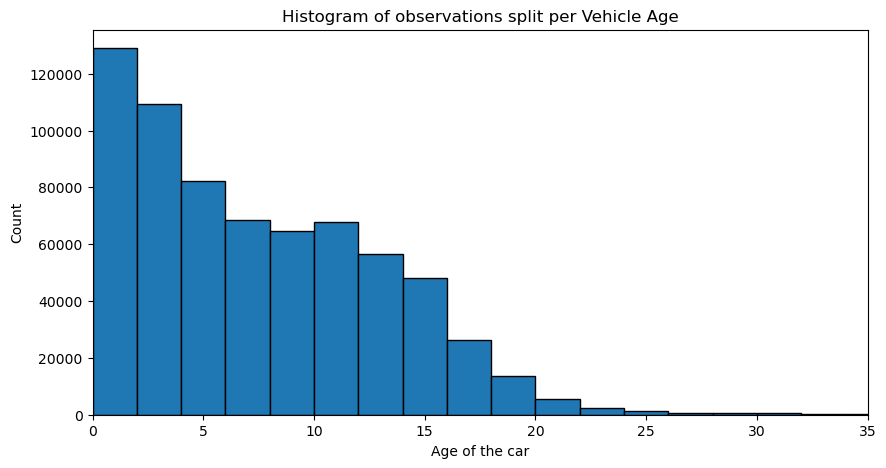

In [ ]:
plt.figure(figsize = (10, 5))
sns.histplot(data = mtpl_freq, x = "VehAge", stat = 'count', binwidth = 2, linewidth = 1, alpha=1)
plt.xlabel("Age of the car")
plt.xlim(0, 35)
plt.title('Histogram of observations split per Vehicle Age')
plt.show()

Now, let's compute the frequency and show it graphically:

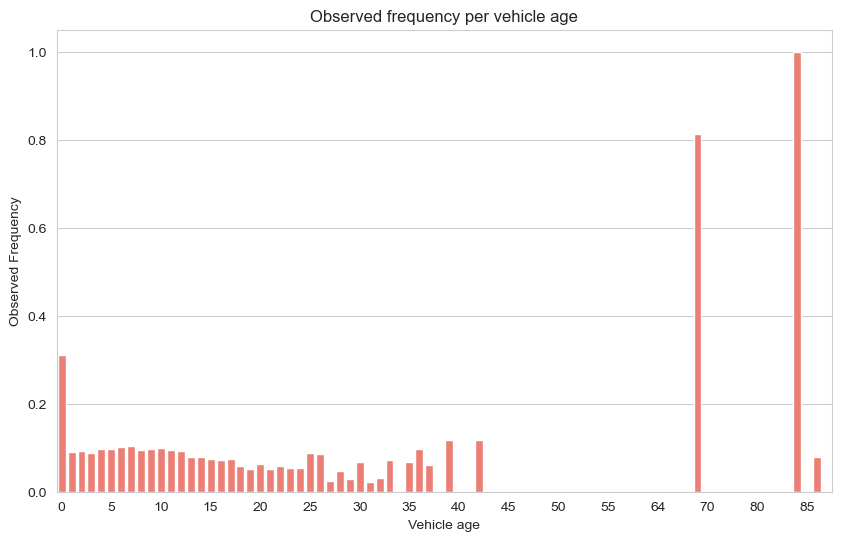

In [ ]:
# Calculation of the Claim Frequency per vehicle age
FreqVehAge = mtpl_freq.groupby("VehAge").agg(sum_claims = ('ClaimNb', 'sum'), sum_expo = ('Exposure', 'sum'))
FreqVehAge["Average_freq"] = FreqVehAge["sum_claims"] / FreqVehAge["sum_expo"]

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Create the bar plot
sns.barplot(x = FreqVehAge.index, y = 'Average_freq', data = FreqVehAge, color='#FF6F61')

# Add labels and title
plt.xlabel('Vehicle age')
plt.ylabel('Observed Frequency')
plt.title('Observed frequency per vehicle age')
plt.xticks(ticks=range(0, len(FreqVehAge), 5))

# Show the plot
plt.show()

Except for the first year, the claims frequency remains relatively stable. For very old cars, average frequency jumps but only few observations are available.   

### Variable Bonus-Malus
The relation between the dependent variable and different explanatory variables is studied. First, the relationship between the observed frequency and variable *Bonus-Malus* is plotted below.

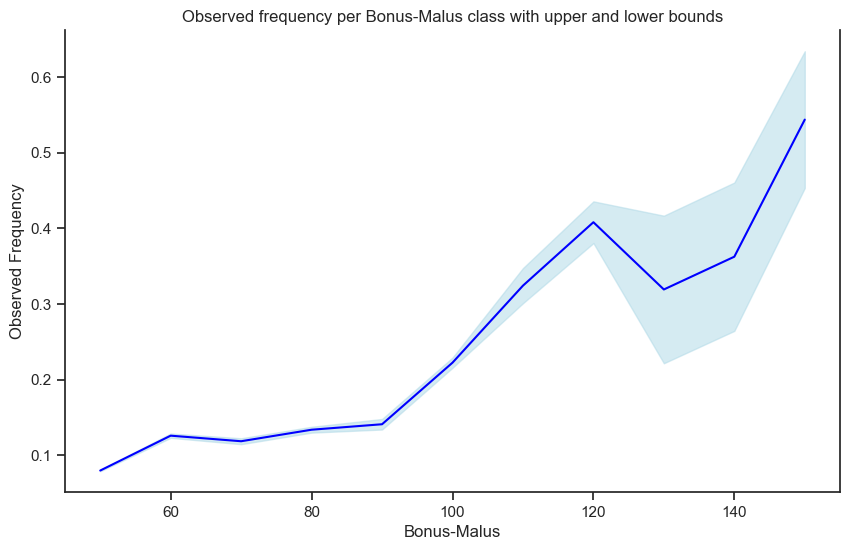

In [ ]:
mtpl_bonmal = mtpl_freq.copy()
mtpl_bonmal["BonusMalus"] = np.minimum(mtpl_bonmal.BonusMalus, 150)   # Values are capped to 150
mtpl_bonmal["BonusMalusGroup"] = np.round(mtpl_bonmal.BonusMalus, -1) # Create groups for each multiplication of a BonusMalus score of 10

# Group by BonusMalusGroup and calculate a 90% confidence interval (σ = 1.645)
Bonus_Malus_table = mtpl_bonmal.groupby("BonusMalusGroup").ClaimNb.sum() / mtpl_bonmal.groupby("BonusMalusGroup").Exposure.sum()
z = 1.645 * mtpl_bonmal.groupby("BonusMalusGroup").ClaimNb.sum()**0.5 / mtpl_bonmal.groupby("BonusMalusGroup").Exposure.sum()

plt.figure(figsize=(10, 6))

Bonus_Malus_frequency = pd.DataFrame(Bonus_Malus_table, columns=["Observed_freq"])
Bonus_Malus_frequency["Upper"] = Bonus_Malus_frequency.Observed_freq + z
Bonus_Malus_frequency["Lower"] = Bonus_Malus_frequency.Observed_freq - z

sns.lineplot(data=Bonus_Malus_frequency, x="BonusMalusGroup", y="Observed_freq", color="blue")
plt.title('Observed frequency per Bonus-Malus class with upper and lower bounds')
plt.fill_between(Bonus_Malus_frequency.index, Bonus_Malus_frequency["Upper"], Bonus_Malus_frequency["Lower"], color='lightblue', alpha=0.5)
plt.ylabel("Observed Frequency")
plt.xlabel("Bonus-Malus")
plt.show()

In the graph above, there is a clear relation between the Bonus-Malus score and the observed frequency of claims. Moreover, the difference between the upper and lower bounds also increases as the Bonus-Malus score increases.

### Variable Driver Age
A graph that shows the relation between *DrivAge* and *ClaimFrequency* is displayed below. The relationship between the two variables appears to be non-linear. For young drivers between 18-20 years, the frequency is noticeably higher. It then decreases as drivers become older. For people older than 30  years-old, the frequency remains relatively stable until 65 years. For older ages, the volatility increases. This is partially due to a lack of observations.

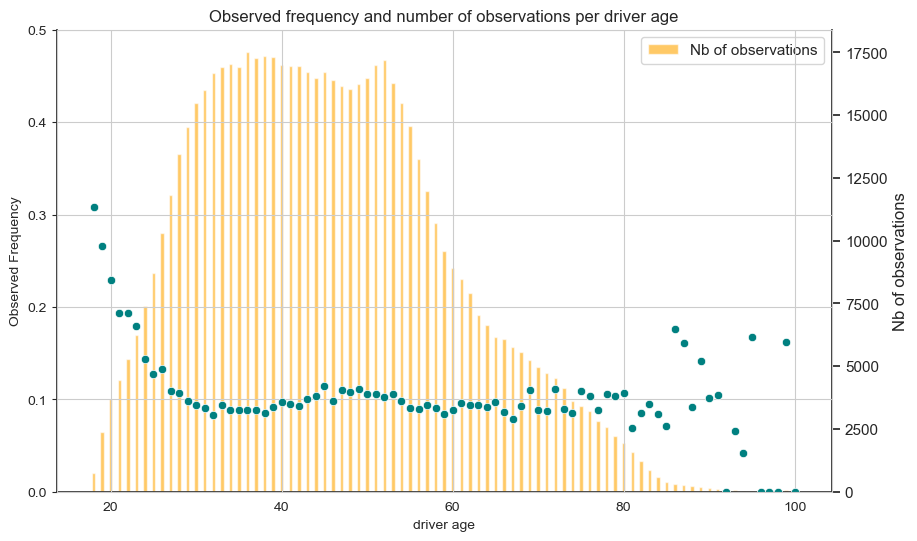

In [ ]:
# Calculation of the Claim Frequency per vehicle age and counting observations
FreqDriverAge = mtpl_freq.groupby("DrivAge").agg(sum_claims = ('ClaimNb', 'sum'), sum_expo = ('Exposure', 'sum'), count_obs = ('ClaimNb', 'count'))
FreqDriverAge["Average_freq"] = FreqDriverAge["sum_claims"] / FreqDriverAge["sum_expo"]

fig, ax1 = plt.subplots(figsize=(10, 6))

# Background settings
custom_params = {"axes.spines.right": True, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

# Create the scatterplot
sns.scatterplot(x = FreqDriverAge.index, y = 'Average_freq', data = FreqDriverAge, ax=ax1, color='teal')

plt.title('Observed frequency and number of observations per driver age')

# Scatter plot on the first y-axis
ax1.set_ylabel('Observed Frequency')
ax1.tick_params(axis='y')
ax1.set_xlabel('driver age')
plt.ylim(0,0.5)

# Bar plot on the second y-axis
ax2 = ax1.twinx()
ax2.bar(x = FreqDriverAge.index,height='count_obs', data = FreqDriverAge, color='orange', alpha=0.6, label='Nb of observations', width=0.4)
ax2.set_ylabel('Nb of observations')
ax2.tick_params(axis='y')
ax2.legend(loc='upper right')

# Bring the first axis to the front
ax1.set_zorder(3)
ax1.patch.set_visible(False)

plt.show()

### Variable Density
Let's now create a graph showing the relationship between *Density* and *ClaimFrequency*. To account for the wide difference between the minimum and maximum density, observations are first split in 50 bins of similar size with ```qcut()```.

C:\Users\bjorn.blom\AppData\Local\Temp\ipykernel_21420\2047359211.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  FreqDensity = mtpl_freq_graph_dens.groupby("Density_cat").agg(sum_claims = ('ClaimNb', 'sum'), sum_expo = ('Exposure', 'sum'))


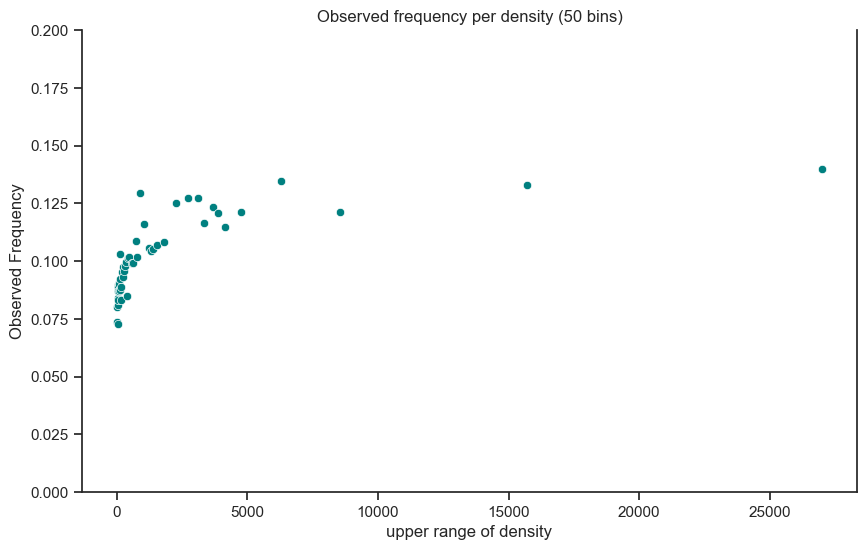

In [ ]:
# Creation of a dataframe with 50 bins of similar size
mtpl_freq_graph_dens = mtpl_freq.copy()
mtpl_freq_graph_dens["Density_cat"] = pd.qcut(mtpl_freq.Density, q = 50, duplicates='drop')

# Bins named using their upper range
bin_upper_range = [i for i in mtpl_freq_graph_dens.Density_cat.cat.categories.right]
mtpl_freq_graph_dens["Density_cat"] = pd.qcut(mtpl_freq.Density, q=50, labels = bin_upper_range, duplicates='drop')

# Calculation of the Claim Frequency per vehicle age and counting observations
FreqDensity = mtpl_freq_graph_dens.groupby("Density_cat").agg(sum_claims = ('ClaimNb', 'sum'), sum_expo = ('Exposure', 'sum'))
FreqDensity["Average_freq"] = FreqDensity["sum_claims"] / FreqDensity["sum_expo"]

fig, ax1 = plt.subplots(figsize=(10, 6))
plt.title('Observed frequency per density (50 bins)')

# Create the scatterplot
sns.scatterplot(x = FreqDensity.index, y = 'Average_freq', data = FreqDensity, ax = ax1, color = 'teal')

# Define axis
ax1.set_ylabel('Observed Frequency')
ax1.tick_params(axis='y')
ax1.set_xlabel('upper range of density')
plt.ylim(0,0.2)
plt.show()

Using a logarithmic scale, it possible to observe a clear relationship. People living in areas with a lower density have on average less accidents than policyholders in urban areas.

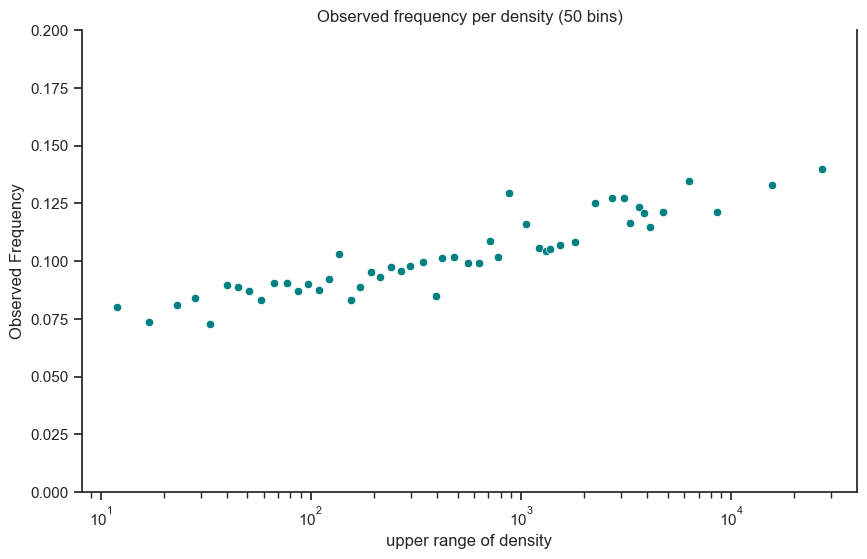

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))
plt.title('Observed frequency per density (50 bins)')

# Create the scatterplot
sns.scatterplot(x = FreqDensity.index, y = 'Average_freq', data = FreqDensity, ax=ax1, color='teal')

# Define axis
ax1.set_ylabel('Observed Frequency')
ax1.set_xscale('log')
ax1.tick_params(axis='y')
ax1.set_xlabel('upper range of density')
plt.ylim(0,0.2)
plt.show()

## 5.2. Preliminary feature treatment <a name="Preliminary_feature_treatment"></a>

### Number of claims treatment
Below, the number of observations per *ClaimNb* values is analyzed.

In [ ]:
# Number of observations per value of ClaimNb
mtpl_freq['ClaimNb'].value_counts().sort_index(ascending=True)

ClaimNb
0     643953
1      32178
2       1784
3         82
4          7
5          2
6          1
8          1
9          1
11         3
16         1
Name: count, dtype: int64

Only few observations exist with a number of claims greater than 3. These observations are rare and might alter the analysis. As a consequence, these values are excluded from the dataset.

In [ ]:
# Treatment 1: Only select policyholders with less than 4 claims and an exposure higher than 1 month
mtpl_freq = mtpl_freq[mtpl_freq['ClaimNb'] < 4]

### Exposure treatment

In this dataset, the dependent variable that will be used is the number of claims, weighted using the exposure. The purpose here is to compare the number of claims per policy over the duration of one year. The exposure represents the period during which the policy is in application.

Let's now take a look at exposure data available:

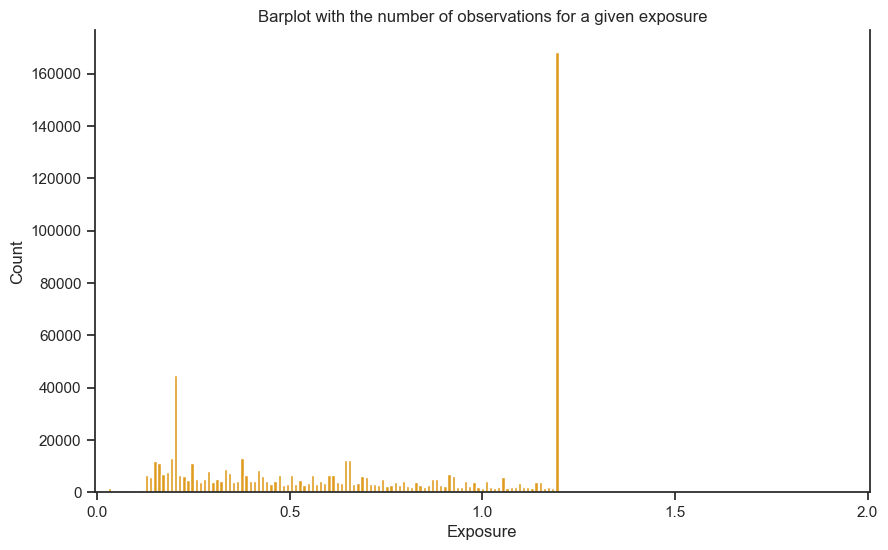

In [ ]:
mtpl_freq_Exp = mtpl_freq_graph_dens.groupby("Exposure").agg(sum_claims = ('Exposure', 'count'))

plt.figure(figsize = (10, 6))

sns.barplot(data=mtpl_freq_Exp, x=mtpl_freq_Exp.index, y='sum_claims', color='orange')

plt.ylabel("Count")
plt.xlabel("Exposure")
plt.title('Barplot with the number of observations for a given exposure')

ticks = np.linspace(0, len(mtpl_freq_Exp) - 1, 5)  # Evenly spaced positions
labels = [f"{i:.1f}" for i in np.linspace(0, 2, 5)]
plt.xticks(ticks=ticks, labels=labels)
plt.show()

The exposure originally ranges from 0.0027 to 2. Practically, that represents an exposure from 1 day to 2 years. Now, let's have a look at the average number of claims per year. For this purpose, the number of claims per observations is divided by the exposure:

In [ ]:
# Exposure before treatment
(mtpl_freq["ClaimNb"] / mtpl_freq["Exposure"]).value_counts().sort_index(ascending=True)

0.000000      643953
0.500000           1
0.520833           1
0.666667           1
0.699301           1
               ...  
300.000000         1
365.000000         3
365.000004         1
366.000000        41
732.000000         3
Name: count, Length: 230, dtype: int64

The blend of extremely limited exposure (minimum one day) with a non-null number of claims means the average claims per year can go as high as 732 without treatment. To avoid significantly skewing the GLM fit, observations with an exposure lower than 1 month (1/12 ≈ 0.08) are discarded:

In [ ]:
# Treatment 2: Only select policyholders with an exposure higher than 1 month
mtpl_freq = mtpl_freq[mtpl_freq['Exposure'] > 0.08]

In [ ]:
# Calculation of the Claim Frequency
mtpl_freq.loc[:, "ClaimFrequency"] = mtpl_freq["ClaimNb"] / mtpl_freq["Exposure"]
mtpl_freq["ClaimFrequency"].value_counts().sort_index(ascending=True)

ClaimFrequency
0.000000     531823
0.500000          1
0.520833          1
0.666667          1
0.699301          1
              ...  
20.000000        13
21.428571         1
22.222222        18
27.272727         1
33.333333         1
Name: count, Length: 207, dtype: int64

### Retreatment to categorical variables

For GLMs to function correctly, numerical explanatory variables need to be subdivided into categories. Generally, this division is made based on grouping similar responding groups together. For example for the vehicle age, we have seen before that the records with a vehicle age of 1 had a different frequency than the once with a vehicle age between 1 and 20.

Below, new variables are created using ```cut()``` from ```pandas```:

In [ ]:
# Define intervals for the explanatory variables:
labelsVehAge = ['0-1', '1-20', '20-25', '25-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-100']
labelsDrivAge = ['18-20', '20-25', '25-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-100']
labelsBonusMalus = ['50-75', '75-100', '100-150', '150-230']
labelsVehPower = ['4-7', '7-9', '9-11', '11-13', '13-15']
labelsDensity = ['0-1000', '1000-2000', '2000-3000', '3000-4000', '4000-5000', '5000-6000', '6000-10000', '10000-30000']

mtpl_freq["VehAge_cat"] = pd.cut(mtpl_freq.VehAge, bins = [0, 1, 20, 25, 30, 40, 50, 60, 70, 80, max(mtpl_freq.DrivAge)], labels = labelsVehAge, include_lowest = True)
mtpl_freq["DrivAge_cat"] = pd.cut(mtpl_freq.DrivAge, bins = [18, 20, 25, 30, 40, 50, 60, 70, 80, max(mtpl_freq.DrivAge)], labels = labelsDrivAge, include_lowest = True)
mtpl_freq["BonusMalus_cat"] = pd.cut(mtpl_freq.BonusMalus, bins = [50, 75, 100, 150, max(mtpl_freq.BonusMalus)], labels = labelsBonusMalus, include_lowest = True)
mtpl_freq["VehPower_cat"] = pd.cut(mtpl_freq.VehPower, bins = [4, 7, 9, 11, 13, max(mtpl_freq.VehPower)], labels = labelsVehPower, include_lowest = True)
mtpl_freq["Density_cat"] = pd.cut(mtpl_freq.Density, bins = [1, 1000, 2000, 3000, 4000, 5000, 6000, 10000, max(mtpl_freq.Density)], labels = labelsDensity, include_lowest = True)

It is important to first conduct the exploratory data analysis (EDA) then specify ranges that make sense. It will improve the effectiveness of the GLM model.

### Split between train and test datasets

As seen in the first programming session, the dataset is divided into training and test datasets. The chosen size of the test dataset is 25% of the observations:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(mtpl_freq.drop(columns=['ClaimNb']), mtpl_freq['ClaimNb'], test_size=0.25, random_state=1)
mtpl_train = X_train
mtpl_train["ClaimNb"] = y_train

## 5.3. Mean-variance relationship <a name="mean_var_rel"></a>

Given that the number of claims per policy is a variable that takes a positive integer value, three main statistical distributions can be used: the Poisson, Binomial and Negative Binomial distributions.

In theory, the choice between one of these three models should depend on the relation between the mean and the variance:
 - Poisson distribution: $\mathbb{E}[Y] = \operatorname{Var}[Y]$
 - Binomial distribution: $\mathbb{E}[Y] > \operatorname{Var}[Y]$
 - Negative Binomial distribution: $\mathbb{E}[Y] < \operatorname{Var}[Y]$

In practice, normally the different distributions are tested on the dataset and the best model is chosen.

Let's investigate the relation between the sample mean and variance in the dataset used.

In [ ]:
mean_freq = mtpl_freq["ClaimNb"].mean()
var_freq = mtpl_freq["ClaimNb"].var()

print("Sample mean: ", mean_freq)
print("Sample variance: ", var_freq)

Sample mean:  0.05897810581862151
Sample variance:  0.062275259334212144


# 5.4. Model with a Poisson distribution<a name="Poisson_distribution"></a>

## GLM with just one explanatory variable<a name="GLM_one_expl"></a>
Recall that, in the theoretical session, the Poisson distibution was introduced to model annual claim frequency $\lambda_{i}$, associated with the explanatory variables $x_{i}$, where *i* represents the $i^{th}$ observation. The relation between the two is:

$$ \lambda_{i} = \exp\big(\beta_{0}\big) \prod_{j=1,..,p-1} \exp\big(\beta_{j} \big)$$

where:
 - *p* is the number of explanatory variables, per category, included in the model;
 - $\exp\big(\beta_{0}\big)$ is the claim frequency for the reference class;
 - $\exp\big(\beta_{j}\big)$ is the impact on the frequency of the $j^{th}$ variable.

First, let's apply this distribution in a model with just one explanatory variable. The chosen variable is *DrivAge_cat*. The relationship between the frequency of claims and this explanatory variable is diplayed above.

Since a Poisson model is expecting a count value, the dependent variable is the number of claims (*ClaimNb*). However, this number of claims is offsetted in the model with the Exposure, which means that the model is taking into account the exposure of a policy holder. It's not advised to use the calculated frequency, since this will screw up the variance of the variable.

In [ ]:
Poisson_1 = sm.formula.glm("ClaimNb ~  C(DrivAge_cat)", \
                              data = mtpl_train, family=sm.families.Poisson(link=sm.families.links.Log()), offset = mtpl_train['Exposure']).fit()
print(Poisson_1.summary())
print("------------------------------------------------------------------------------------------------------------------------")
print("Single metrics of interest:")
# AIC
print(f'AIC: {Poisson_1.aic:.2f}')
# BIC
print(f'BIC: {Poisson_1.bic_llf:.2f}')
# Deviance
print(f"Deviance: {Poisson_1.deviance:.2f}")

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               422406
Model:                            GLM   Df Residuals:                   422397
Model Family:                 Poisson   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -95715.
Date:                Tue, 26 Nov 2024   Deviance:                   1.4357e+05
Time:                        09:11:08   Pearson chi2:                 4.61e+05
No. Iterations:                     6   Pseudo R-squ. (CS):           0.001314
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

All levels of the explanatory variable are statistically significant as underlined by their p-values. Moreover, different metrics are displayed. A complete list of metrics can be obtained using the command ```dir(Poisson_1)```.

Using the estimated coefficients, predictions of the expected number of claims can also be computed manually. For example, for a driver of 35 years old, the expeced number of claims is:

In [ ]:
parameter_settings = pd.DataFrame({
    'DrivAge_cat': ['30-40']
})
predictions_statsmodel = Poisson_1.predict(parameter_settings)
print("Prediction using statsmodel: ", predictions_statsmodel[0].round(4))

Prediction using statsmodel:  0.026


In [ ]:
predictions_manual = np.exp(Poisson_1.params[Poisson_1.params.index == "Intercept"].values * 1) * \
np.exp(Poisson_1.params[Poisson_1.params.index == "C(DrivAge_cat)[T.30-40]"].values * 1)
print("Prediction calculated manually: ", predictions_manual[0].round(4))

Prediction calculated manually:  0.026


## GLM with additional explanatory variables
A model with more explanatory variables is developed below:

In [ ]:
Poisson_2 = sm.formula.glm("ClaimNb ~ VehAge_cat + DrivAge_cat + BonusMalus_cat + VehPower_cat + VehBrand + Density_cat", \
                              data = mtpl_train, family=sm.families.Poisson(link=sm.families.links.Log()), offset = mtpl_train['Exposure']).fit()
print(Poisson_2.summary())
print("------------------------------------------------------------------------------------------------------------------------")
print("Single metrics of interest:")
# AIC
print(f'AIC: {Poisson_2.aic:.2f}')
# BIC
print(f'BIC: {Poisson_2.bic_llf:.2f}')
# Deviance
print(f"Deviance: {Poisson_2.deviance:.2f}")

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               422406
Model:                            GLM   Df Residuals:                   422364
Model Family:                 Poisson   Df Model:                           41
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -94515.
Date:                Tue, 26 Nov 2024   Deviance:                   1.4117e+05
Time:                        09:11:23   Pearson chi2:                 4.51e+05
No. Iterations:                    19   Pseudo R-squ. (CS):           0.006971
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

Compared to the first model ```Poisson_1```, the pseudo R-squared in ```Poisson_2``` increased while the AIC and the deviance decreased. Thus, this model performs better then the first one.

# 5.4. Model with a Negative Binomial distribution <a name="NB_distribution"></a>

The preliminary analysis highlighted that the data presents overdispersion, *i.e.* the sample variance is (slightly) greater than the sample mean. Therefore, a more appropriate distribution is the Negative Binomial.
More information on such distribution can be found [here](https://mc-stan.org/docs/functions-reference/unbounded_discrete_distributions.html).

## Alpha in the Negative Binomial
In such distribution, the parameter $\alpha$ needs to be estimated prior to the computation of the GLM.
This positive parameter appears in the relation between the mean $\mu$ and the variance $\sigma^2$ of the distribution:
$$ \sigma^2 = \mu + \alpha \frac{\mu^2}{2}$$
The next python cell shows how such equation is used to estimate $\alpha$. This parameter can be estimated with other methods: Cameron-Trivedi, Pinquet and Maximum-Likelihood. Below, a model is developed with the same explanatory variables and link function used in ```Poisson_2```, but with a Negative Binomial distribution.

In [ ]:
# First alpha is estimated:
data_alpha = mtpl_train['ClaimNb'].values
# Calculate mean and variance of the claim counts
mean_claims = np.mean(data_alpha)
variance_claims = np.var(data_alpha)
# Estimate alpha
alpha_cap = (mean_claims ** 2) / (variance_claims - mean_claims)
print(f"Estimated alpha: {alpha_cap}")

#GLM model
Neg_Bin = sm.formula.glm("ClaimNb ~ VehAge_cat + DrivAge_cat + BonusMalus_cat + VehPower_cat + VehBrand + Density_cat", \
                              data = mtpl_train, family=sm.families.NegativeBinomial(alpha=alpha_cap, link=sm.families.links.Log()), offset = mtpl_train['Exposure']).fit()
print(Neg_Bin.summary())
print("------------------------------------------------------------------------------------------------------------------------")
print("Single metrics of interest:")
# AIC
print(f'AIC: {Neg_Bin.aic:.2f}')
# BIC
print(f'BIC: {Neg_Bin.bic_llf:.2f}')
# Deviance
print(f"Deviance: {Neg_Bin.deviance:.2f}")

Estimated alpha: 1.0151081292933704
                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               422406
Model:                            GLM   Df Residuals:                   422364
Model Family:        NegativeBinomial   Df Model:                           41
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -94380.
Date:                Tue, 26 Nov 2024   Deviance:                   1.2192e+05
Time:                        09:18:05   Pearson chi2:                 4.26e+05
No. Iterations:                    19   Pseudo R-squ. (CS):           0.006429
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------

Using metrics such as the AIC or the pseudo R-squared to compare models with different distributions is not always appropriate. For example, since more parameters need to be computed when using the Negative Binomial compared to the Poisson distribution, the AIC penalizes the Negative Binomial distribution.
Nervertheless, the AIC in this case suggests that the model using the Negative Binomial is better compared to the Poisson one. However, the pseudo-R-squared decreases slightly with the Negative Binomial.

## Wald Test
The significance of each explanatory variable can be tested using the Wald test, which enables to test for the significance of all the categories at the same time:

$$ H_0 : \beta_{x}(j)=0  \forall j $$

where *j*  is a certain category of variable *x* and $\beta_{x}(j)$ is the associated coefficient.

If the value of this test is greater than a certain significance level, for example 5%, the null hypothesis is accepted. More information about this test can be found [here](https://www.stat.cmu.edu/~siva/teaching/705/lec21.pdf). Below, this test is used to verify the significance of the used explanatory variables. The result shows that all variables are statistically significant at a 5% confidence level.

In [ ]:
wald_test_results = Neg_Bin.wald_test_terms(scalar=True)
print(wald_test_results)

                       chi2        P>chi2  df constraint
Intercept       2767.458189  0.000000e+00              1
VehAge_cat       445.666979  2.419784e-90              9
DrivAge_cat      314.779241  2.935198e-63              8
BonusMalus_cat  1683.520704  0.000000e+00              3
VehPower_cat      22.052829  1.956254e-04              4
VehBrand          23.931971  7.783023e-03             10
Density_cat      132.286157  2.091869e-25              7


Even if variables are all significant when taking all the categories together, a better subdivision within each variable can be performed. As suggested by the p-values in the model ```Neg_Bin```, adjacent intervals "40-50", ..., "80-90" for variable *VehAge_cat* can be merged together given that all intervals are not statistically relevant. Below, the new variable is called *VehAge_cat2*.
<br/>Similarly, some intervals of the variable *VehPower_cat* are not statistically significant. They are therefore merged with adjacent intervals. Moreover, the only statistically significant value of *VehBrand* is *B12*, hence this variable isn't used anymore in the next model.
<br/>

In [ ]:
Neg_Bin.pvalues

Intercept                      0.000000e+00
VehAge_cat[T.1-20]             1.650953e-86
VehAge_cat[T.20-25]            1.525151e-19
VehAge_cat[T.25-30]            7.051530e-07
VehAge_cat[T.30-40]            3.553436e-06
VehAge_cat[T.40-50]            3.406147e-02
VehAge_cat[T.50-60]            9.988987e-01
VehAge_cat[T.60-70]            8.947935e-01
VehAge_cat[T.70-80]            9.991577e-01
VehAge_cat[T.80-100]           2.376422e-01
DrivAge_cat[T.20-25]           1.944768e-11
DrivAge_cat[T.25-30]           1.242713e-19
DrivAge_cat[T.30-40]           8.933579e-19
DrivAge_cat[T.40-50]           4.397157e-05
DrivAge_cat[T.50-60]           5.098919e-08
DrivAge_cat[T.60-70]           1.902408e-07
DrivAge_cat[T.70-80]           1.732559e-03
DrivAge_cat[T.80-100]          2.155024e-02
BonusMalus_cat[T.75-100]      7.109782e-149
BonusMalus_cat[T.100-150]     5.032827e-286
BonusMalus_cat[T.150-230]      1.486678e-22
VehPower_cat[T.7-9]            1.000694e-02
VehPower_cat[T.9-11]           8

Below the model where changes are implemented:

In [ ]:
# Change of grouping for the explanatory variables:
labelsVehAge_2 = ['0-1', '1-20', '20-25', '25-30', '30-40', '40-100']
labelsVehPower_2 = ['5-7', '7-9', '9-15']

mtpl_freq["VehAge_cat2"] = pd.cut(mtpl_freq.VehAge, bins = [0, 1, 20, 25, 30, 40, max(mtpl_freq.DrivAge)], labels = labelsVehAge_2, include_lowest = True)
# Another way to do this is using "replace": mtpl_freq["VehAge_cat"].replace(['2-3','3-10'],'2-10')
mtpl_freq["VehPower_cat2"] = pd.cut(mtpl_freq.VehPower, bins = [5, 7, 9, max(mtpl_freq.VehPower)], labels = labelsVehPower_2, include_lowest = True)
mtpl_freq['VehBrand_cat'] = mtpl_freq["VehBrand"].replace(['B2','B3', 'B4', 'B5', 'B6', 'B10', 'B11', 'B13', 'B14'],'Other')

# The new variables must be included also in the test and train datasets
X_train, X_test, y_train, y_test = train_test_split(mtpl_freq.drop(columns=['ClaimNb']), mtpl_freq['ClaimNb'], test_size=0.25, random_state=1)
mtpl_train = X_train
mtpl_train["ClaimNb"] = y_train

In [ ]:
# First alpha is estimated:
data_alpha = mtpl_train['ClaimNb'].values
# Calculate mean and variance of the claim counts
mean_claims = np.mean(data_alpha)
variance_claims = np.var(data_alpha)
# Estimate alpha
alpha_cap = (mean_claims ** 2) / (variance_claims - mean_claims)
print(f"Estimated alpha: {alpha_cap}")

# GLM model with Negative Binomial distribution
Neg_Bin_2 = sm.formula.glm("ClaimNb ~ VehAge_cat2 + DrivAge_cat + VehPower_cat2 + BonusMalus_cat + Density_cat", \
                              data = mtpl_train, family=sm.families.NegativeBinomial(alpha=alpha_cap, link=sm.families.links.Log()), offset = mtpl_train['Exposure']).fit()
print(Neg_Bin_2.summary())
print("------------------------------------------------------------------------------------------------------------------------")
print("Single metrics of interest:")
# AIC
print(f'AIC: {Neg_Bin_2.aic:.2f}')
# BIC
print(f'BIC: {Neg_Bin_2.bic_llf:.2f}')
# Deviance
print(f"Deviance: {Neg_Bin_2.deviance:.2f}")

Estimated alpha: 1.0151081292933704
                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               350410
Model:                            GLM   Df Residuals:                   350384
Model Family:        NegativeBinomial   Df Model:                           25
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -79435.
Date:                Tue, 26 Nov 2024   Deviance:                   1.0228e+05
Time:                        09:22:09   Pearson chi2:                 3.51e+05
No. Iterations:                     6   Pseudo R-squ. (CS):           0.006531
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------

In this last model, the AIC and BIC are lower compared to previous models. Therefore, it will be considered the best model so far. It is possible to continue improving the model, for example by improving the *VehPower* categories, such that each category is statistically significant at 5% significance level. Currently the 9-15 category is just above the 5% threshold.
<br/>

In [ ]:
Neg_Bin_2.pvalues

Intercept                      0.000000e+00
VehAge_cat2[T.1-20]            7.237065e-70
VehAge_cat2[T.20-25]           1.708969e-14
VehAge_cat2[T.25-30]           1.057404e-05
VehAge_cat2[T.30-40]           6.097920e-06
VehAge_cat2[T.40-100]          3.303520e-02
DrivAge_cat[T.20-25]           3.310111e-09
DrivAge_cat[T.25-30]           1.125784e-16
DrivAge_cat[T.30-40]           1.288691e-16
DrivAge_cat[T.40-50]           5.582740e-05
DrivAge_cat[T.50-60]           1.793784e-07
DrivAge_cat[T.60-70]           4.257352e-07
DrivAge_cat[T.70-80]           9.000612e-04
DrivAge_cat[T.80-100]          1.767602e-02
VehPower_cat2[T.7-9]           1.112699e-05
VehPower_cat2[T.9-15]          5.166647e-01
BonusMalus_cat[T.75-100]      2.478477e-134
BonusMalus_cat[T.100-150]     1.323595e-237
BonusMalus_cat[T.150-230]      7.625837e-20
Density_cat[T.1000-2000]       2.199349e-09
Density_cat[T.2000-3000]       3.568663e-06
Density_cat[T.3000-4000]       3.406929e-12
Density_cat[T.4000-5000]       1

Let us use the chosen model on the test dataset to see if the model can accurately predict the frequency of claims. First, the model is used to predict values on the test dataset. Then, the predicted values are compared to the values of the test dataset and an histogram of the difference is plotted.

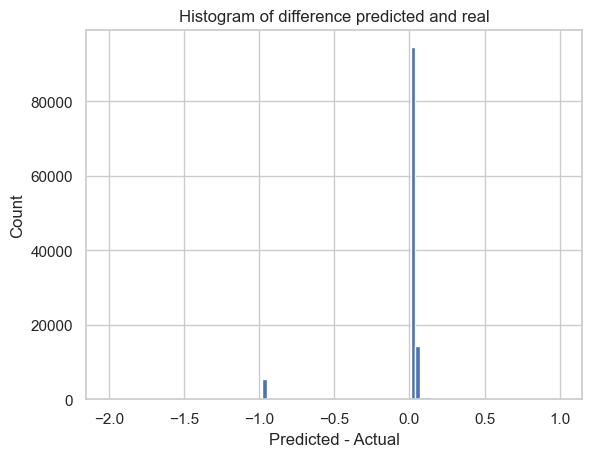

In [ ]:
yhat = Neg_Bin_2.predict(X_test)
plt.hist(yhat - y_test, range=[-2,1], bins=100)
plt.xlabel('Predicted - Actual')
plt.ylabel('Count')
plt.title('Histogram of difference predicted and real')
plt.show()

Predicted values are in line with real ones.

A graph to compare the mean per *Density* category of the predicted and real values is displayed below:


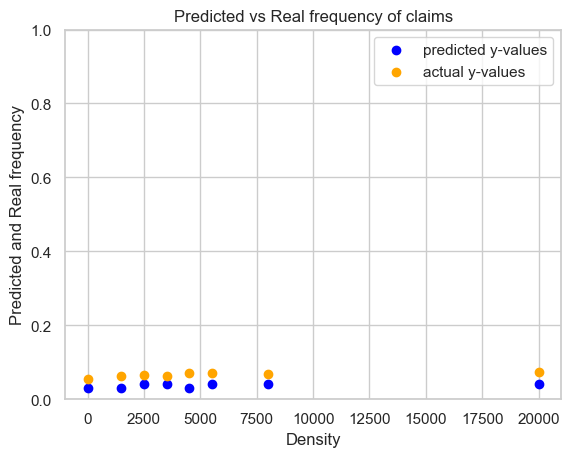

In [ ]:
# Group by Density_cat and calculate the mean
yhat_mean = round(Neg_Bin_2.predict(X_test).groupby(X_test.Density_cat, observed=True).mean(), 2)

# Convert the intervals into numerical representation (e.g., midpoints) for scatter plot
x_values=[0]
for i in range(len(labelsDensity)):
 a, b = map(int, labelsDensity[i].split('-'))
 if i==0:
  x_values[i]==int(float(a)+float(b)/2)
 else:
  x_values.append(int(float(a)+float(b))/2) # Calculate midpoints

# Plot predicted values in blue
plt.scatter(x_values, yhat_mean, color='blue')

# Plot actual values in orange
plt.scatter(x_values, y_test.groupby(X_test.Density_cat, observed=True).mean(), color='orange')

plt.xlabel('Density')
plt.ylabel('Predicted and Real frequency')
plt.title('Predicted vs Real frequency of claims')
plt.legend(['predicted y-values', 'actual y-values'])
plt.ylim(0,1)
plt.show()

A graph to compare the mean per *Driver Age* category of the predicted and real values is displayed below:


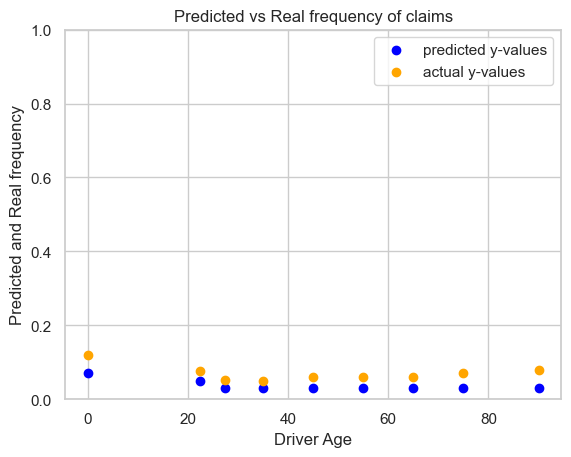

In [ ]:
# Group by DrivAge_cat2 and calculate the mean
yhat_mean = round(Neg_Bin_2.predict(X_test).groupby(X_test.DrivAge_cat, observed=True).mean(), 2)

# Convert the intervals into numerical representation (e.g., midpoints) for scatter plot
x_values=[0]
for i in range(len(labelsDrivAge)):
 a, b = map(int, labelsDrivAge[i].split('-'))
 if i==0:
  x_values[i]==int(float(a)+float(b)/2)
 else:
  x_values.append(int(float(a)+float(b))/2) # Calculate midpoints

# Plot predicted values in blue
plt.scatter(x_values, yhat_mean, color='blue')

# Plot actual values in orange
plt.scatter(x_values, y_test.groupby(X_test.DrivAge_cat, observed=True).mean(), color='orange')

plt.xlabel('Driver Age')
plt.ylabel('Predicted and Real frequency')
plt.title('Predicted vs Real frequency of claims')
plt.legend(['predicted y-values', 'actual y-values'])
plt.ylim(0,1)
plt.show()

A graph to compare the mean per BonusMalus category of the predicted and real values is displayed below:

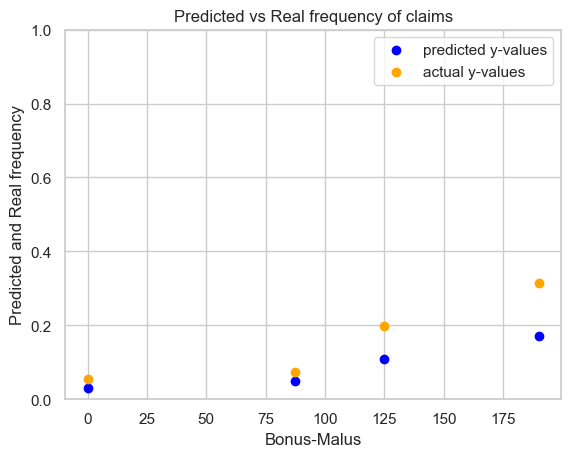

In [ ]:
# Group by BonusMalus_cat and calculate the mean
yhat_mean = round(Neg_Bin_2.predict(X_test).groupby(X_test.BonusMalus_cat, observed=True).mean(), 2)

# Convert the intervals into numerical representation (e.g., midpoints) for scatter plot
x_values=[0]
for i in range(len(labelsBonusMalus)):
 a, b = map(int, labelsBonusMalus[i].split('-'))
 if i==0:
  x_values[i]==int(float(a)+float(b)/2)
 else:
  x_values.append(int(float(a)+float(b))/2) # Calculate midpoints

# Plot predicted values in blue
plt.scatter(x_values, yhat_mean, color='blue')

# Plot actual values in orange
plt.scatter(x_values, y_test.groupby(X_test.BonusMalus_cat, observed=True).mean(), color='orange')

plt.xlabel('Bonus-Malus')
plt.ylabel('Predicted and Real frequency')
plt.title('Predicted vs Real frequency of claims')
plt.legend(['predicted y-values', 'actual y-values'])
plt.ylim(0,1)
plt.show()

# 5.5. Severity dataset and Gamma distirbution<a name="sev_data"></a>
In ```Section 1```, the dataset on the severity of claims was imported.

In [ ]:
mtpl_sev.columns

Index(['IDpol', 'ClaimAmount'], dtype='object')

It contains only two colums: *ClaimAmount* on the severity of claims and *IDpol*, a variable that allows to connect this dataset with the dataset on frequency claims. Below, the two datasets are merged. Observations corresponding to extreme values of *ClaimAmount* are discarded as they may alter predictions.

In [ ]:
#Count of observations for different values
mtpl_sev["ClaimAmount_cat"] = pd.cut(mtpl_sev.ClaimAmount, bins = [0, 1000, 2000, 3000, 4000, 5000, 8000, 10000, 15000, 30000, max(mtpl_sev.ClaimAmount)], include_lowest = True)
print(mtpl_sev['ClaimAmount_cat'].value_counts().sort_index(ascending=True))

# Merging information from the dataset on frequency
mtpl_sev = pd.merge(mtpl_sev, mtpl_freq, on='IDpol')

# Select claim amounts lower than 10000€
mtpl_sev = mtpl_sev[mtpl_sev['ClaimAmount'] < 10001]

ClaimAmount_cat
(-0.001, 1000.0]          8302
(1000.0, 2000.0]         14410
(2000.0, 3000.0]          1497
(3000.0, 4000.0]           748
(4000.0, 5000.0]           432
(5000.0, 8000.0]           555
(8000.0, 10000.0]          210
(10000.0, 15000.0]         183
(15000.0, 30000.0]         151
(30000.0, 4075400.56]      151
Name: count, dtype: int64


An histogram showing the number of observations for different values of the dependent variable is shown below:

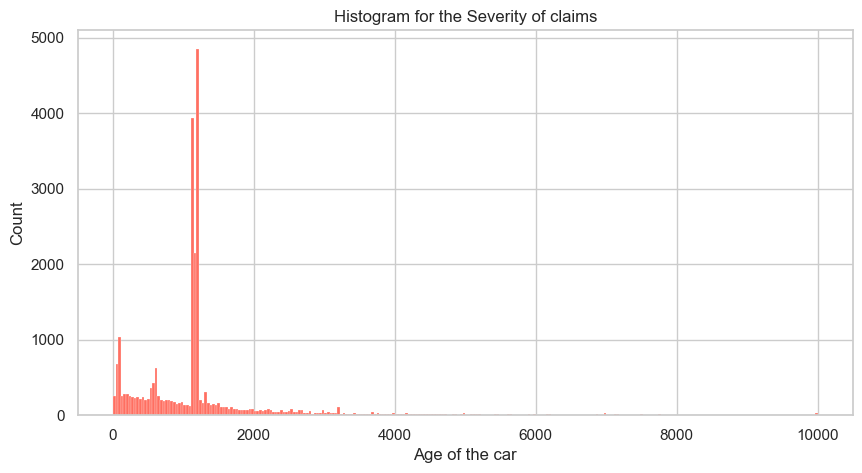

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize = (10, 5))
sns.histplot(data = mtpl_sev, x = "ClaimAmount", stat = 'count', alpha=1, color='#FF6F61')
plt.xlabel("Age of the car")
plt.title('Histogram for the Severity of claims')
plt.show()

To model the severity of claims per policy with GLMs, the Gamma distribution is often used. This distribution allows the dependent variable to only have positive values, which is very appropriate for the severity of claims, given that a claim happened. More information on this distribution can be found [here](https://www.math.umd.edu/~millson/teaching/STAT400fall18/slides/article14.pdf). Below, the dataset is first divided into training and test sets. A GLM is then fitted to predict the severity of claims with a Gamma distribution, using the same explanatory variables of model ```Neg_Bin_2```.

In [ ]:
# The new variable needs to be included also in the test and train datasets
X_train, X_test, y_train, y_test = train_test_split(mtpl_sev.drop(columns=['ClaimAmount']), mtpl_sev['ClaimAmount'], test_size=0.25, random_state=1)
mtpl_train = X_train
mtpl_train["ClaimAmount"] = y_train

# GLM model with Poisson distribution
Gamma_1 = sm.formula.glm("ClaimAmount ~ VehAge_cat2 + DrivAge_cat2 + BonusMalus_cat + VehPower_cat2 + VehBrand_cat + Density_cat", \
                              data = mtpl_train, family=sm.families.Gamma(link=sm.families.links.Log())).fit()
print(Gamma_1.summary())
print("------------------------------------------------------------------------------------------------------------------------")
print("Single metrics of interest:")
# AIC
print(f'AIC: {Gamma_1.aic:.2f}')
# BIC
print(f'BIC: {Gamma_1.bic_llf:.2f}')
# Deviance
print(f"Deviance: {Gamma_1.deviance:.2f}")

                 Generalized Linear Model Regression Results                  
Dep. Variable:            ClaimAmount   No. Observations:                15910
Model:                            GLM   Df Residuals:                    15884
Model Family:                   Gamma   Df Model:                           25
Link Function:                    Log   Scale:                         0.90791
Method:                          IRLS   Log-Likelihood:            -1.2989e+05
Date:                Tue, 26 Nov 2024   Deviance:                       12604.
Time:                        09:08:10   Pearson chi2:                 1.44e+04
No. Iterations:                    11   Pseudo R-squ. (CS):           0.003633
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

Predicted values on the test dataset are compared to the actual observations. Below, three graphs are displayed grouped by different explanatory variables, .

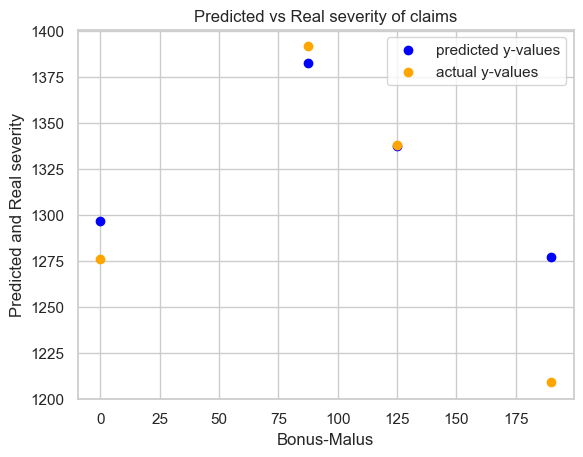

In [ ]:
# Group by BonusMalus_cat and calculate the mean
yhat_mean = round(Gamma_1.predict(X_test).groupby(X_test.BonusMalus_cat, observed=True).mean(), 2)

# Convert the intervals into numerical representation (e.g., midpoints) for scatter plot
x_values=[0]
for i in range(len(labelsBonusMalus)):
 a, b = map(int, labelsBonusMalus[i].split('-'))
 if i==0:
  x_values[i]==int(float(a)+float(b)/2)
 else:
  x_values.append(int(float(a)+float(b))/2) # Calculate midpoints

# Plot predicted values in blue
plt.scatter(x_values, yhat_mean, color='blue')

# Plot actual values in orange
plt.scatter(x_values, y_test.groupby(X_test.BonusMalus_cat, observed=True).mean(), color='orange')

plt.xlabel('Bonus-Malus')
plt.ylabel('Predicted and Real severity')
plt.title('Predicted vs Real severity of claims')
plt.legend(['predicted y-values', 'actual y-values'])
plt.show()

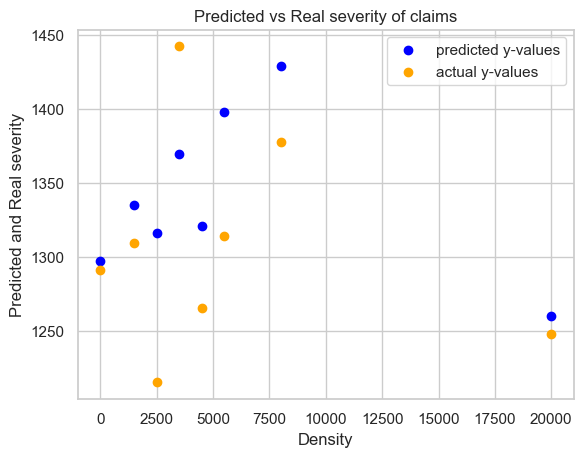

In [ ]:
# Group by Density_cat and calculate the mean
yhat_mean = round(Gamma_1.predict(X_test).groupby(X_test.Density_cat, observed=True).mean(), 2)

# Convert the intervals into numerical representation (e.g., midpoints) for scatter plot
x_values=[0]
for i in range(len(labelsDensity)):
 a, b = map(int, labelsDensity[i].split('-'))
 if i==0:
  x_values[i]==int(float(a)+float(b)/2)
 else:
  x_values.append(int(float(a)+float(b))/2) # Calculate midpoints

# Plot predicted values in blue
plt.scatter(x_values, yhat_mean, color='blue')

# Plot actual values in orange
plt.scatter(x_values, y_test.groupby(X_test.Density_cat, observed=True).mean(), color='orange')

plt.xlabel('Density')
plt.ylabel('Predicted and Real severity')
plt.title('Predicted vs Real severity of claims')
plt.legend(['predicted y-values', 'actual y-values'])
plt.show()

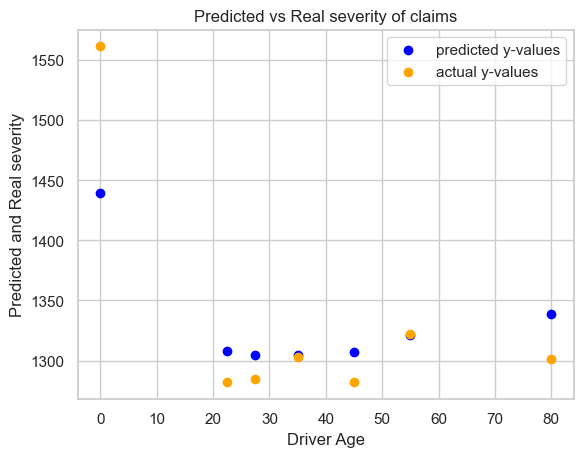

In [ ]:
# Group by DrivAge_cat and calculate the mean
yhat_mean = round(Gamma_1.predict(X_test).groupby(X_test.DrivAge_cat, observed=True).mean(), 2)

# Convert the intervals into numerical representation (e.g., midpoints) for scatter plot
x_values=[0]
for i in range(len(labelsDrivAge)):
 a, b = map(int, labelsDrivAge[i].split('-'))
 if i==0:
  x_values[i]==int(float(a)+float(b)/2)
 else:
  x_values.append(int(float(a)+float(b))/2) # Calculate midpoints

# Plot predicted values in blue
plt.scatter(x_values, yhat_mean, color='blue')

# Plot actual values in orange
plt.scatter(x_values, y_test.groupby(X_test.DrivAge_cat, observed=True).mean(), color='orange')

plt.xlabel('Driver Age')
plt.ylabel('Predicted and Real severity')
plt.title('Predicted vs Real severity of claims')
plt.legend(['predicted y-values', 'actual y-values'])
plt.show()

Graphs above show that predictions are quite close to actual values.

# Summary <a name="Summary"></a>
In this session, different supervized learning models have been introduced.
 - First, the standard **linear model** is presented.
      - Different **metrics to compare models' performance** are investigated.
      - Methods to adequately **choose explanatory variables** are implemented.
      - The use of both numerical and categorical explanatory variables is explained.
 - Different **GLMs** are used to predict the expected number of claims over 1 year in motor insurance, and the severity of a claim, given that the claim happened.
      - Different **statistical distributions for the dependent variable** are presented (poisson, negative binomial and gamma distributions).
      - Grouping of numerical explanatory variables and an analysis of predicted values are discussed.